In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from functools import partial

In [2]:
from modAL.batch import uncertainty_batch_sampling
from modAL.models import ActiveLearner

In [3]:
# Set our RNG for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [4]:
bc = load_breast_cancer()
X_raw = bc['data']
y_raw = bc['target']

In [5]:
# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_bc = pca.fit_transform(X=X_raw)

In [6]:
# Isolate the data we'll need for plotting.
x_component, y_component = transformed_bc[:, 0], transformed_bc[:, 1]

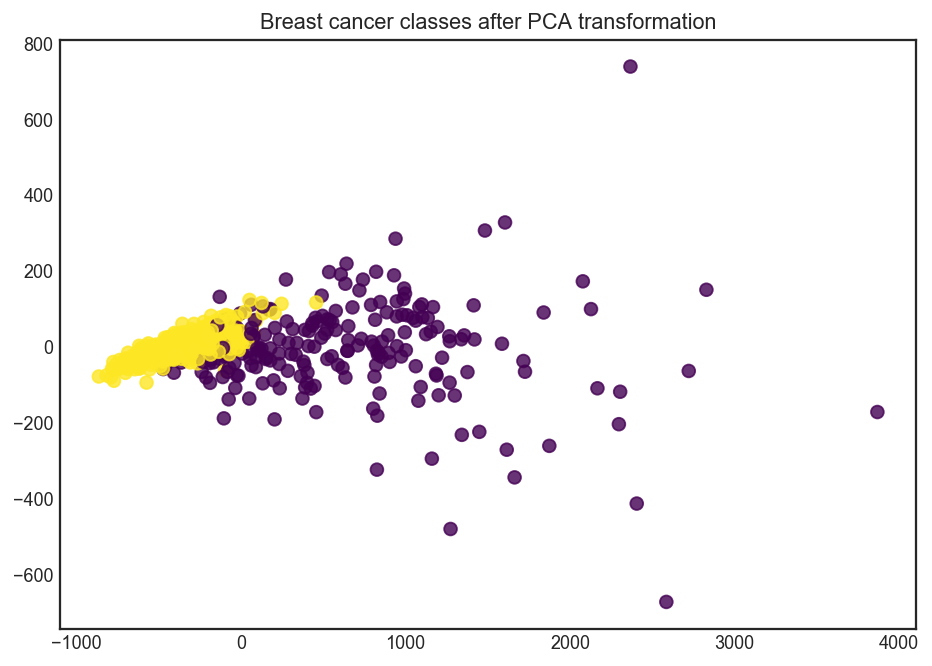

In [7]:
# Plot our dimensionality-reduced (via PCA) dataset.
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(8.5, 6), dpi=130)
    plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
    plt.title('Breast cancer classes after PCA transformation')
    plt.show()

In [8]:
# convert to dataframe
df = pd.DataFrame(bc.data, columns=bc.feature_names)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [9]:
# Isolate our examples for our labeled dataset.
# Randomly choose 3 examples
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

In [10]:
X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

In [11]:
?plt.scatter

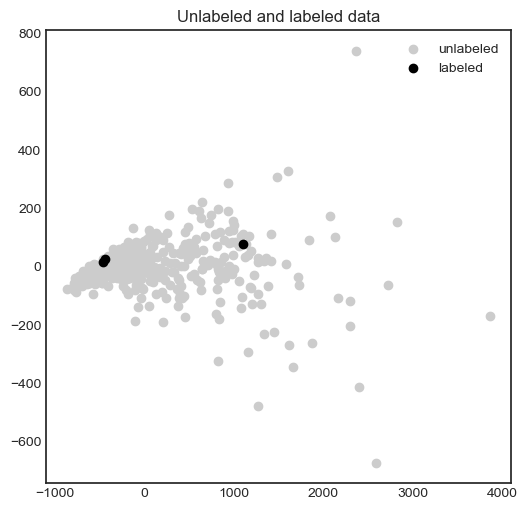

In [12]:
# Visualize the training data.
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(6, 6), dpi=100)
    plt.scatter(transformed_bc[:, 0], transformed_bc[:, 1], c='0.8', label='unlabeled')
    plt.scatter(transformed_bc[training_indices, 0], transformed_bc[training_indices, 1], c='k', label='labeled')
    plt.title('Unlabeled and labeled data')
    plt.legend()
    plt.show()

In [13]:
# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [14]:
# Specify our core estimator.
knn = KNeighborsClassifier(n_neighbors=3)

In [15]:
# Pre-set our batch sampling to retrieve 3 samples at a time.
BATCH_SIZE = 3
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)

In [16]:
# Specify our active learning model.
learner = ActiveLearner(
    estimator=knn,
    X_training=X_train,
    y_training=y_train,
    query_strategy=preset_batch
)

In [17]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

In [18]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

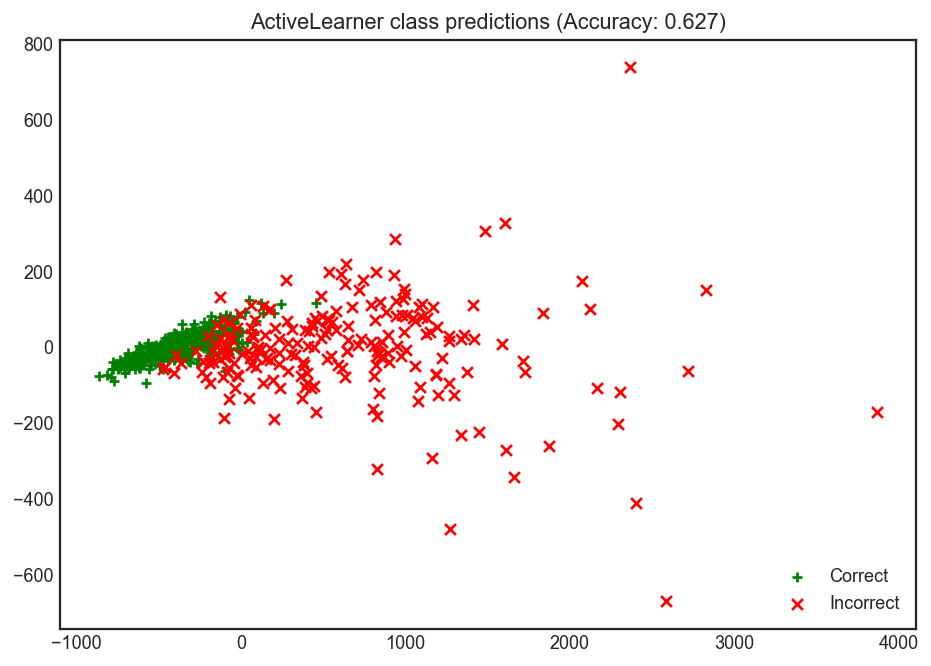

In [19]:
# Plot our classification results.
with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
    ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct')
    ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect')
    ax.legend(loc='lower right')
    ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
    plt.show()

In [20]:
# Pool-based sampling
N_RAW_SAMPLES = 20
N_QUERIES = N_RAW_SAMPLES // BATCH_SIZE
N_QUERIES

6

In [21]:
performance_history = [unqueried_score]

Accuracy after query 1: 0.7083


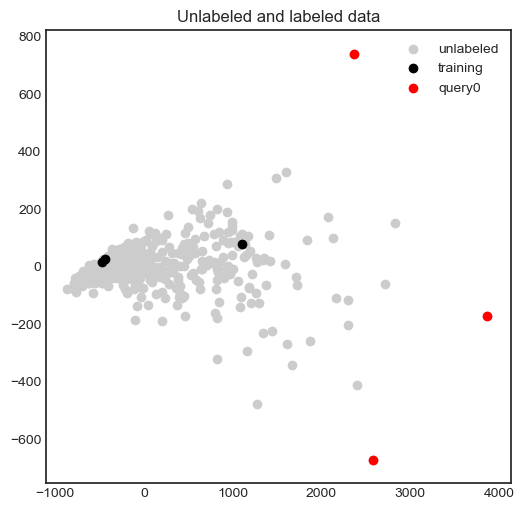

Accuracy after query 2: 0.8770


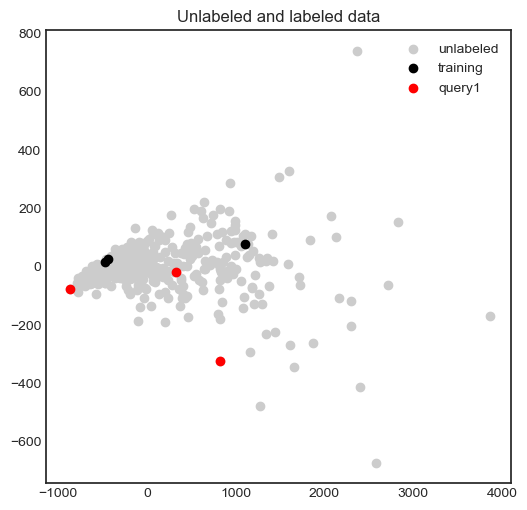

Accuracy after query 3: 0.9016


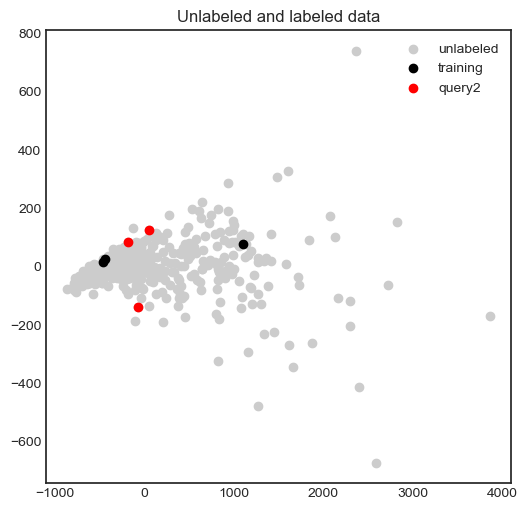

Accuracy after query 4: 0.9139


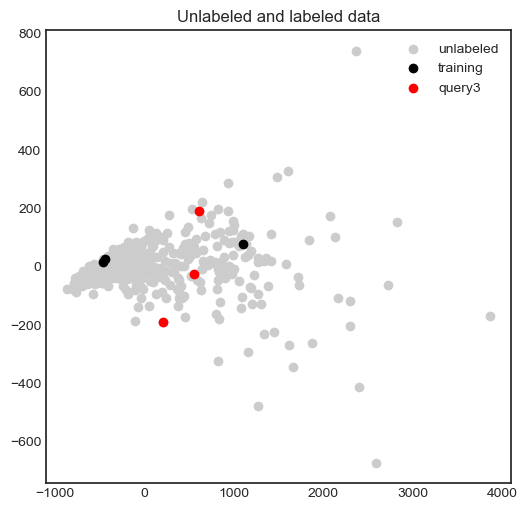

Accuracy after query 5: 0.8840


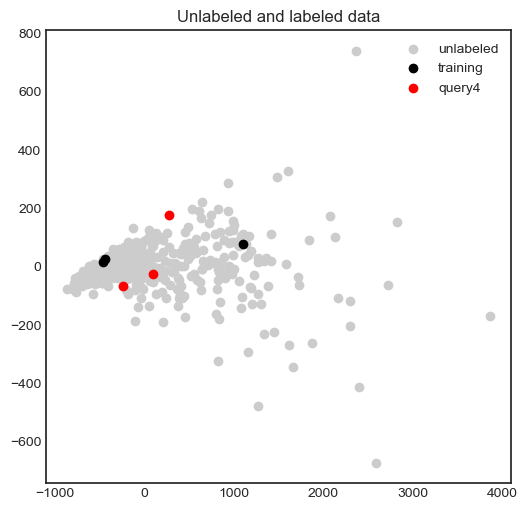

Accuracy after query 6: 0.8998


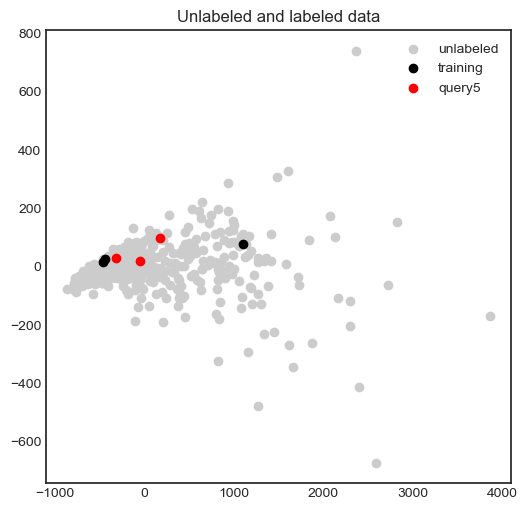

In [22]:
for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool)

    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index], y_pool[query_index]
    learner.teach(X=X, y=y)

    # Remove the queried instance from the unlabeled pool.
    X_pool = np.delete(X_pool, query_index, axis=0)
    y_pool = np.delete(y_pool, query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(X_raw, y_raw)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)

    # Visualize the instances selected for query.
    if index != -1:
        selected = pca.transform(query_instance)

        with plt.style.context('seaborn-white'):
            plt.figure(figsize=(6, 6), dpi=100)
            plt.scatter(transformed_bc[:, 0], transformed_bc[:, 1], c='0.8', label='unlabeled')
            plt.scatter(transformed_bc[training_indices, 0], transformed_bc[training_indices, 1], c='k',
                        label='training')
            plt.scatter(selected[:, 0], selected[:, 1], c='r', label='query'+str(index))
            plt.title('Unlabeled and labeled data')
            plt.legend()
            plt.show()

In [ ]:
# Plot our performance over time.
with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

    ax.plot(performance_history)
    ax.scatter(range(len(performance_history)), performance_history, s=13)

    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=N_QUERIES + 3, integer=True))
    ax.xaxis.grid(True)

    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
    ax.set_ylim(bottom=0, top=1)
    ax.yaxis.grid(True, linestyle='--', alpha=1/2)

    ax.set_title('Incremental classification accuracy')
    ax.set_xlabel('Query iteration')
    ax.set_ylabel('Classification Accuracy')

    plt.show()

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

In [ ]:
# Plot our updated classification results once we've trained our learner.
with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

    ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct')
    ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect')

    ax.set_title('Classification accuracy after {n} queries (* {batch_size} samples/query = {total} samples): {final_acc:.3f}'.format(
        n=N_QUERIES,
        batch_size=BATCH_SIZE,
        total=N_QUERIES * BATCH_SIZE,
        final_acc=performance_history[-1]
    ))
    ax.legend(loc='lower right')

    plt.show()